In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-12-06 15:54:26.758222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 15:54:27.081712: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
ReadList = ["Mass", "evt_trig", "fourjetmasstev",

        "P1high_MTeV", "P1low_MTeV",
        "P2high_MTeV", "P2low_MTeV",
        "P3high_MTeV", "P3low_MTeV",

        "P1high_dR", "P1low_dR",
        "P2high_dR", "P2low_dR",
        "P3high_dR", "P3low_dR",]

In [3]:
def add_more_cols(DF):
    DF["Truth"] = (DF["Mass"] > 0).astype(int)

In [4]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    if Mass == 0:
        TrainingRows = 100000*12
        TestingRows = 50000*12
        File = "ML_TTree/tree_ML_MCRun2_QCD_2M_stride30.root"
        
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(ReadList, library="pd")
    
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    
    add_more_cols(DF)
    
    #TrainingRows = int(len(DF.index)*0.8)
    #TestingRows = int(len(DF.index)*0.2)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [5]:
Masses = [0, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
ShuffMasses = [1500, 2000, 700, 1250, 800, 500, 1750, 900, 600, 3000, 0, 1000, 2500]

#from random import shuffle
#shuffle(Masses)
#print(Masses)

SanityCheckPlots = True

In [6]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, ShuffMasses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root




Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_QCD_2M_stride30.root

Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Memory used: 0.8215255737304688GB


In [7]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 3000]
TrainingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth
0,1500,1,2.704828,1.700352,0.610556,1.409994,1.005733,0.745035,0.721242,2.816456,1.963035,2.817796,3.070193,1.367526,1.369786,1
1,1500,1,3.371880,1.966599,0.436298,1.820704,0.540437,1.528359,1.183368,2.251184,0.883072,2.165907,1.042149,3.011746,1.925203,1
2,1500,1,2.779582,1.547107,1.209831,1.240119,0.992836,0.932032,0.697950,3.207705,4.951296,2.775085,2.800040,2.803926,2.339084,1
3,1500,1,2.692902,1.532380,1.057830,1.361241,0.852709,0.985676,0.499733,3.139951,2.689687,1.784107,2.231670,1.370615,0.958000,1
4,1500,1,3.075986,1.717547,1.213302,1.419409,1.318065,1.098026,0.318212,2.598754,2.982298,2.786366,2.489041,2.276923,0.580094,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,2500,1,4.843406,2.941079,1.531750,2.327936,2.208685,1.201905,0.880429,2.899367,2.412200,2.510848,3.241366,1.035555,0.856280,1
2399996,2500,1,7.299561,4.081045,2.304379,3.930004,1.786276,2.549230,2.499520,2.648357,2.442202,2.582660,2.703146,2.354283,1.530727,1
2399997,2500,1,6.188074,3.471816,1.576412,3.392574,0.392261,2.543328,2.388519,3.053971,1.847593,2.593473,0.684202,2.866569,2.481415,1
2399998,2500,1,5.052891,2.447173,2.251503,2.435331,0.653245,2.117892,1.914285,2.986039,3.546042,2.547125,1.495102,2.500628,2.187966,1


In [8]:
TrainingDF.dtypes

Mass                int32
evt_trig            int32
fourjetmasstev    float64
P1high_MTeV       float64
P1low_MTeV        float64
P2high_MTeV       float64
P2low_MTeV        float64
P3high_MTeV       float64
P3low_MTeV        float64
P1high_dR         float64
P1low_dR          float64
P2high_dR         float64
P2low_dR          float64
P3high_dR         float64
P3low_dR          float64
Truth               int64
dtype: object

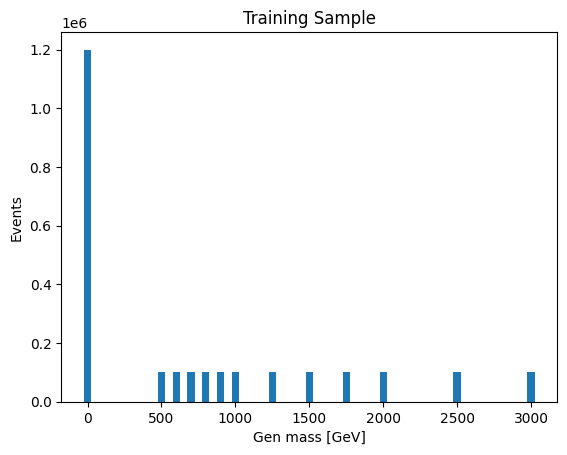

In [9]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((max(Masses) - min(Masses))/50) + 1,
             range = [min(Masses)-25, max(Masses)+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

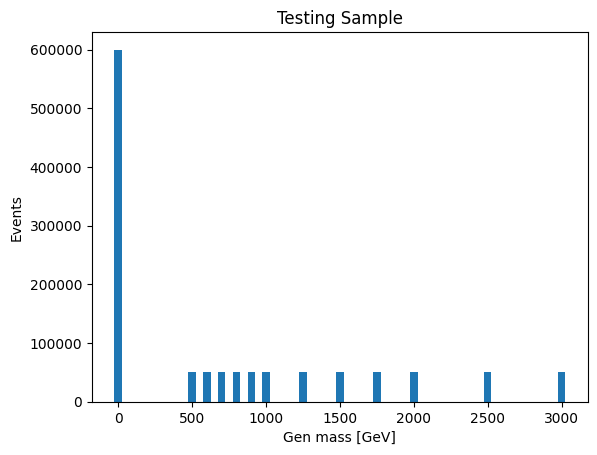

In [10]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((max(Masses) - min(Masses))/50) + 1,
             range = [min(Masses)-25, max(Masses)+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

/tmp/ipykernel_668/1985655967.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


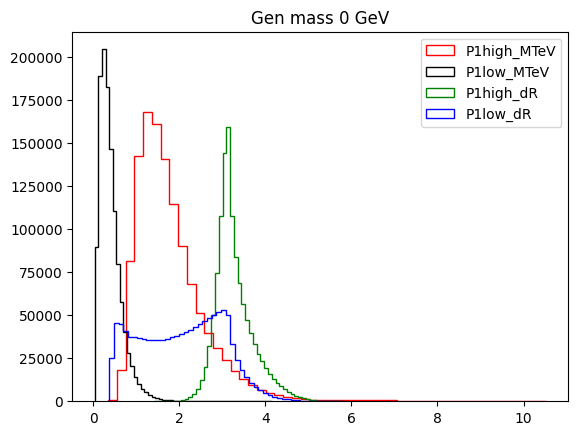

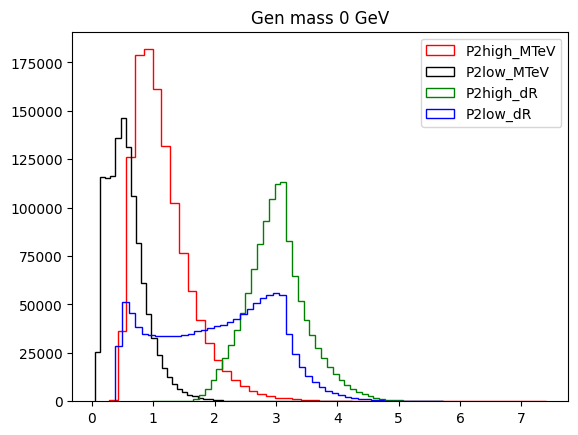

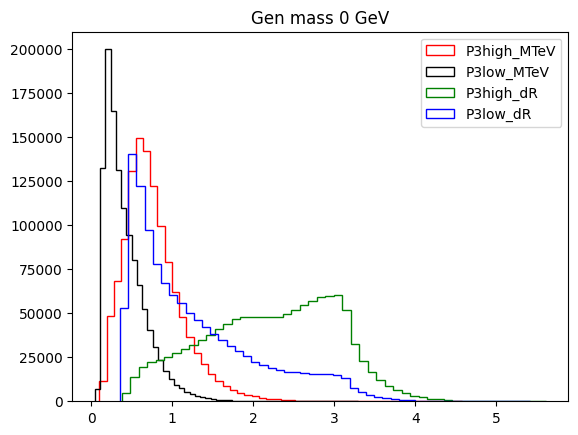

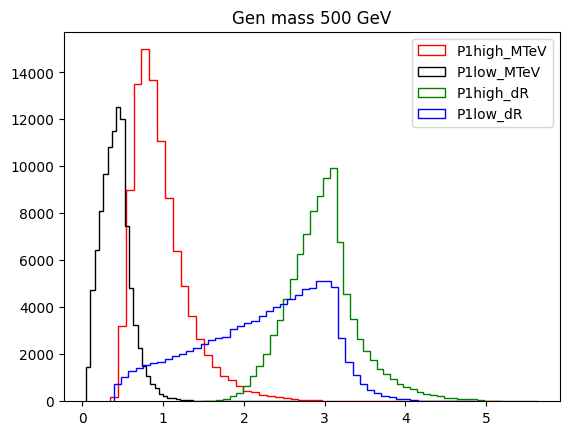

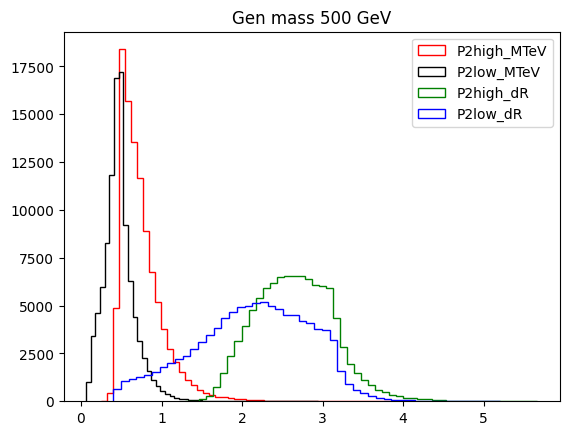

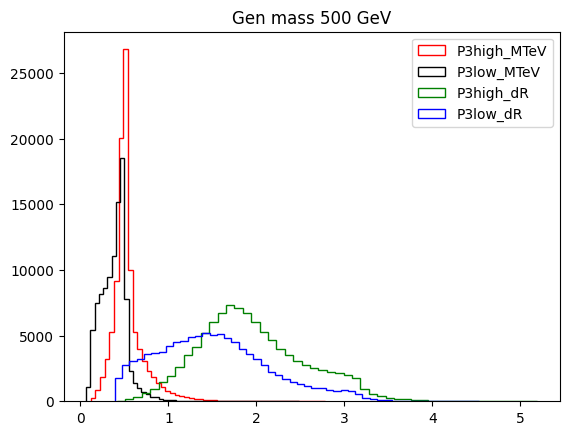

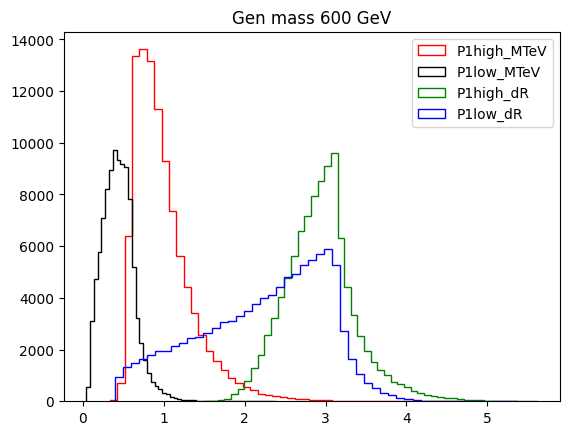

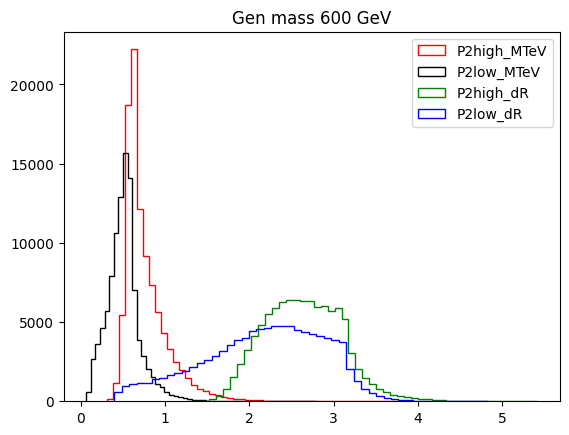

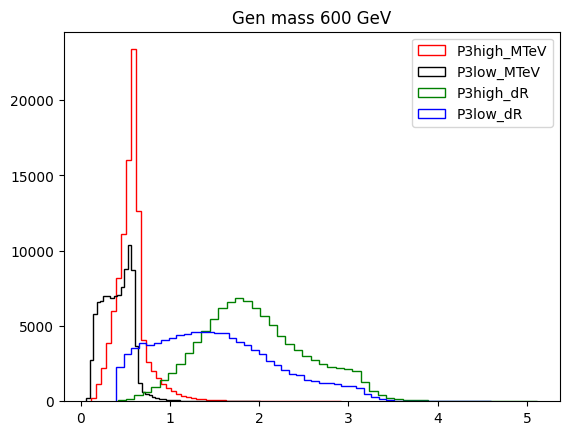

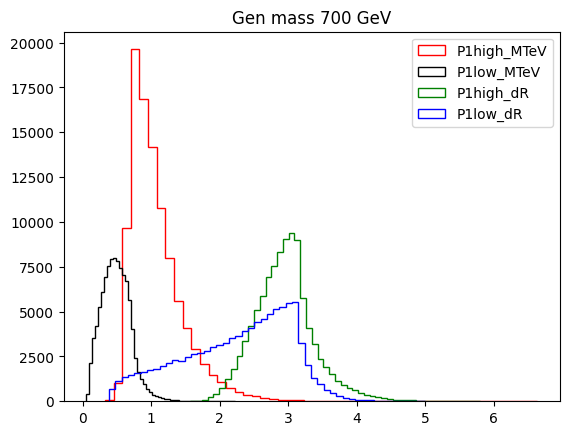

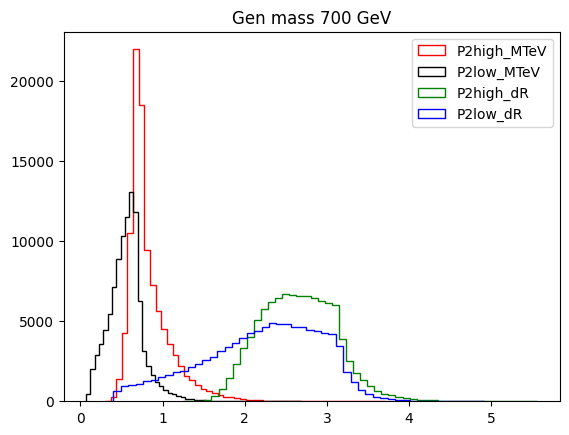

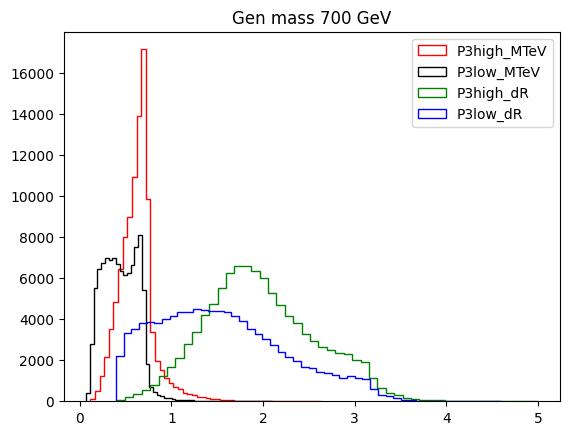

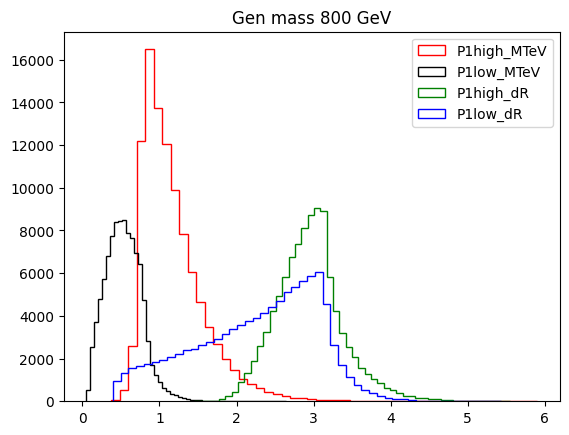

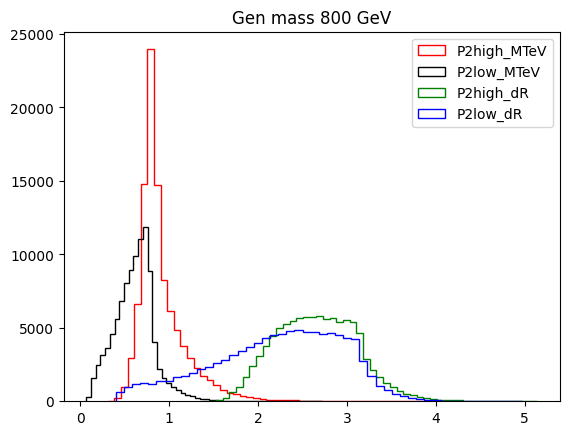

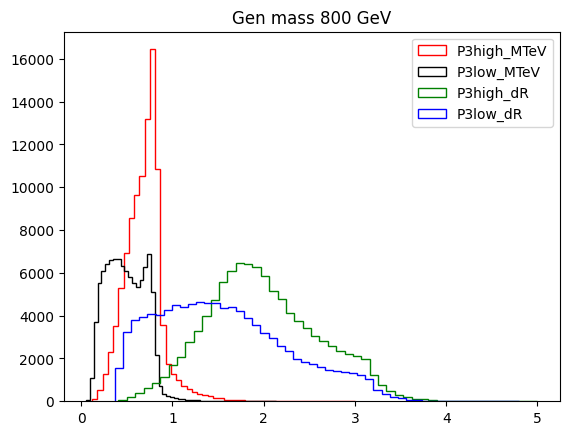

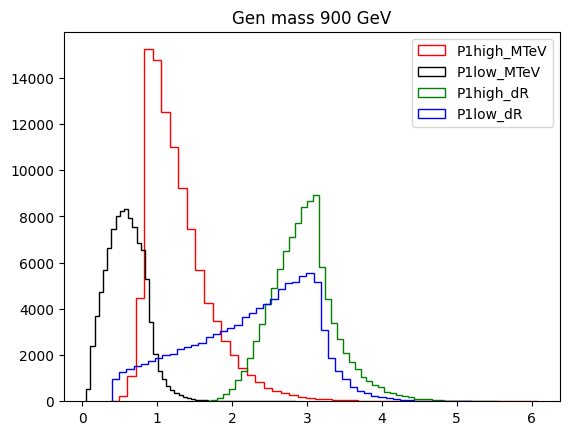

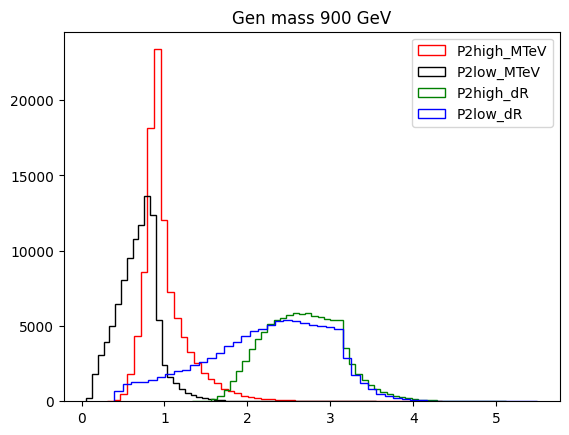

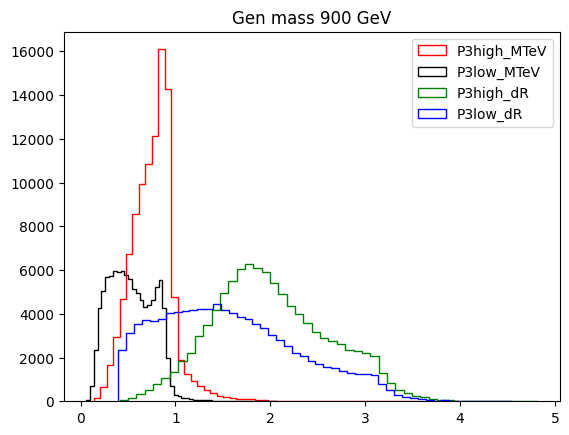

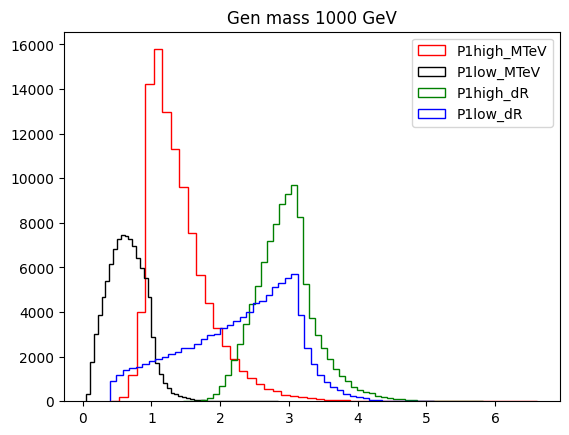

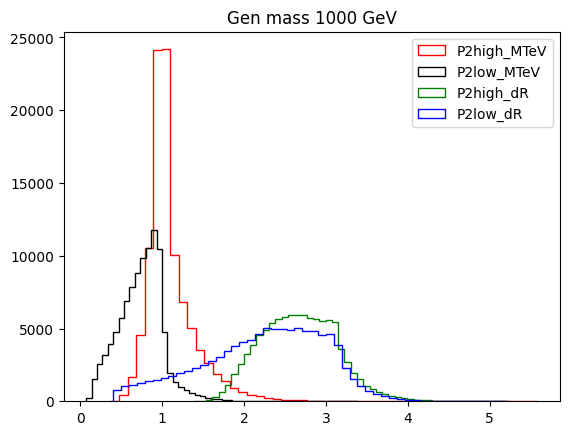

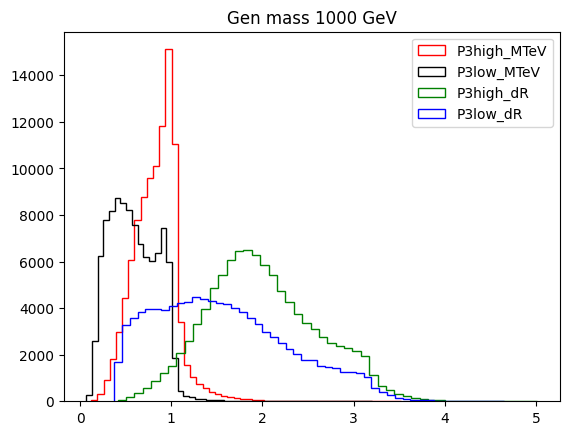

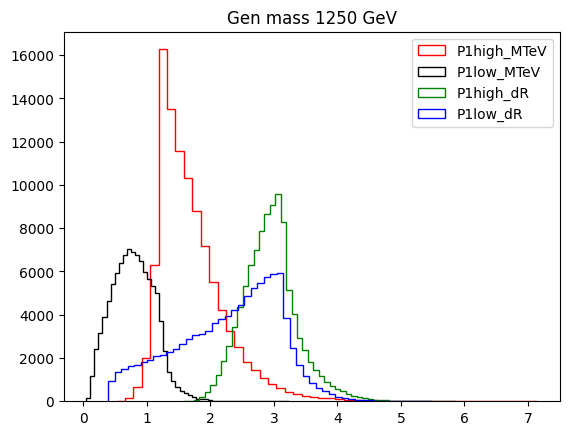

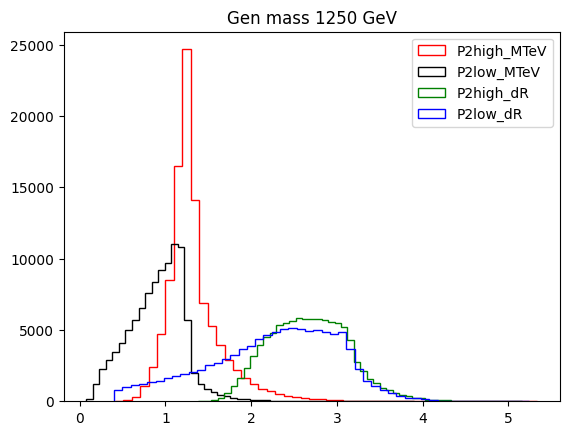

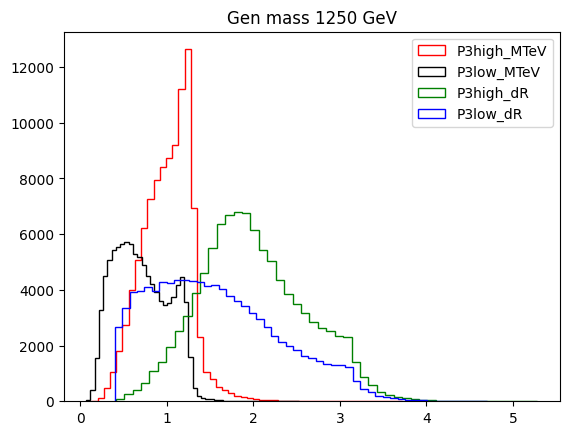

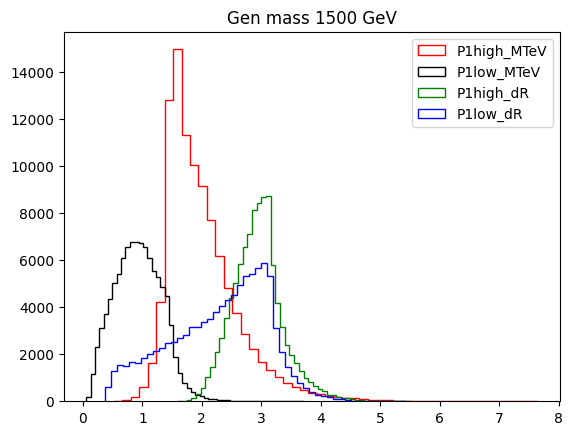

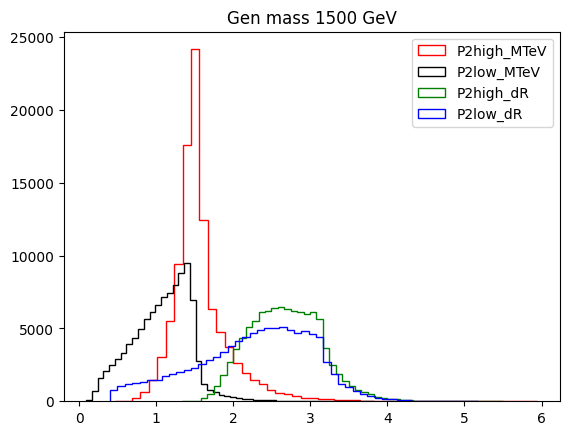

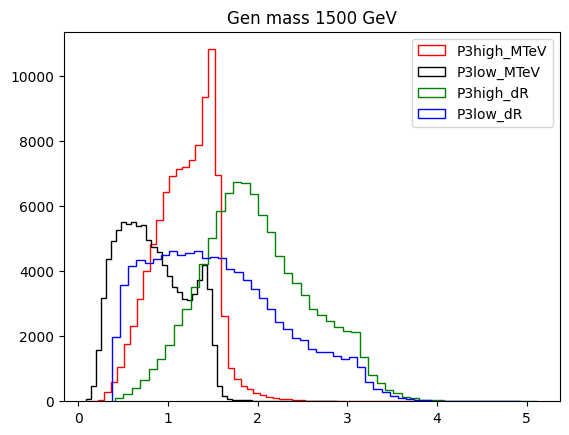

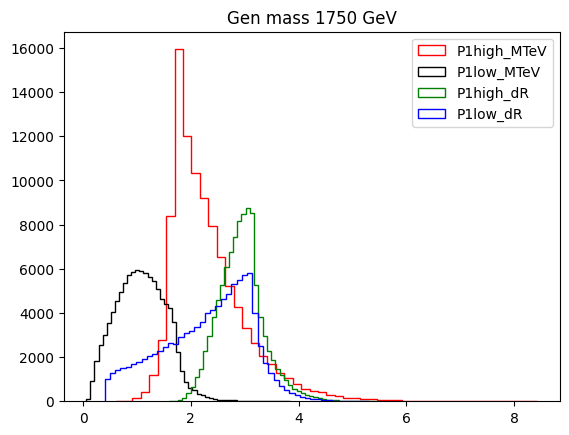

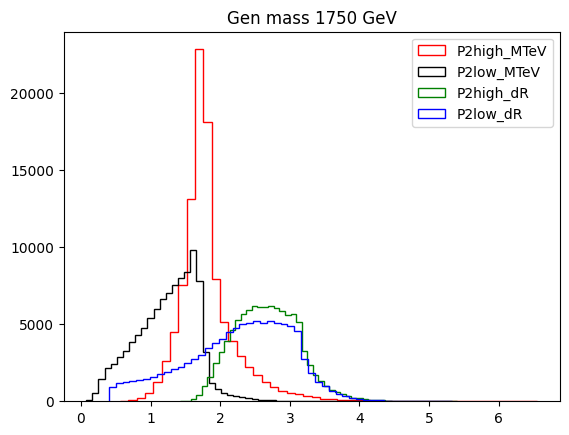

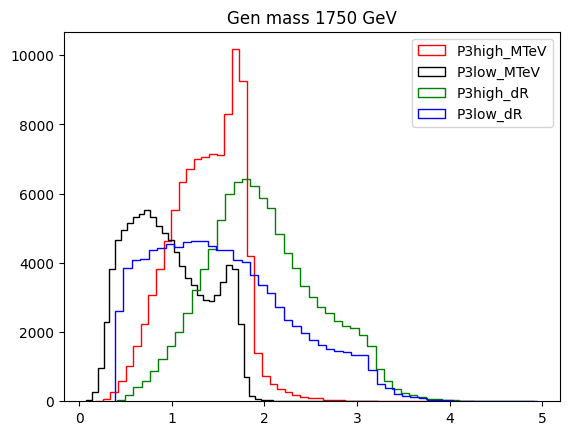

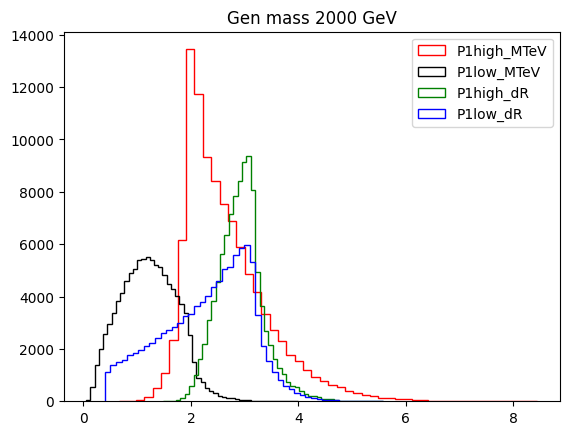

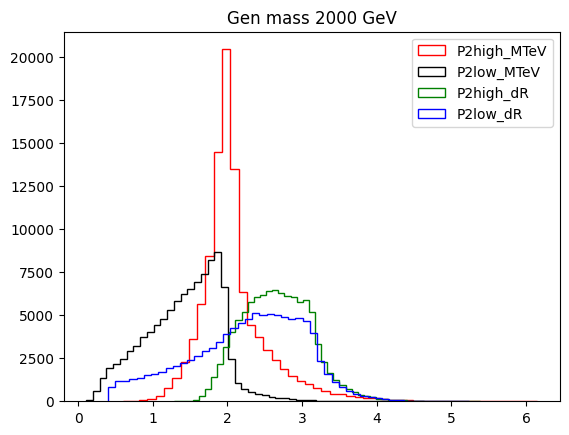

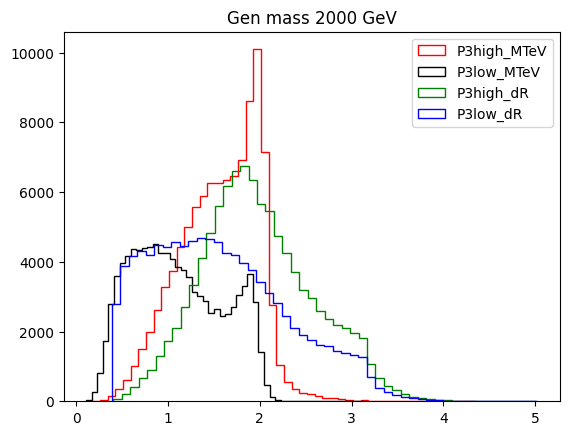

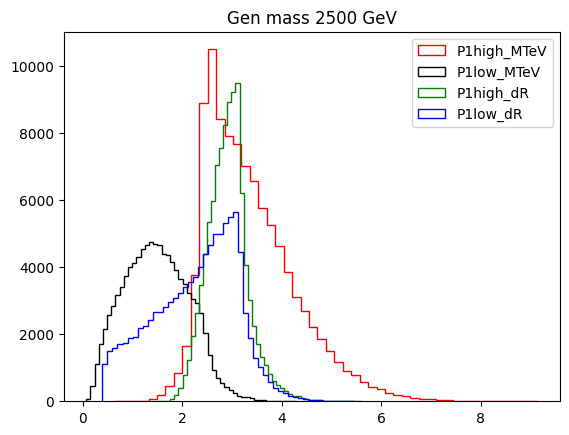

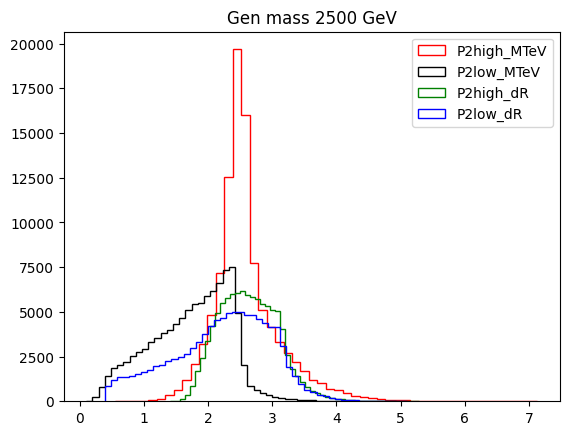

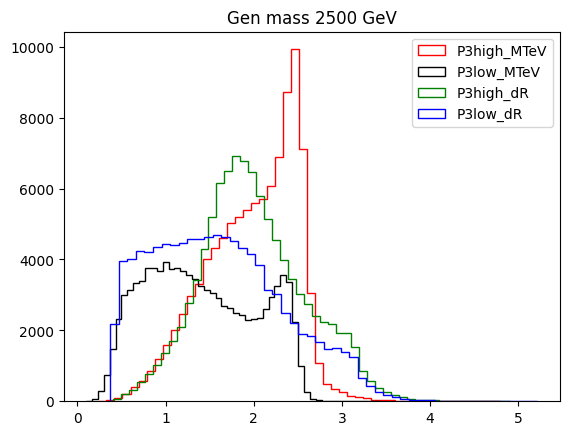

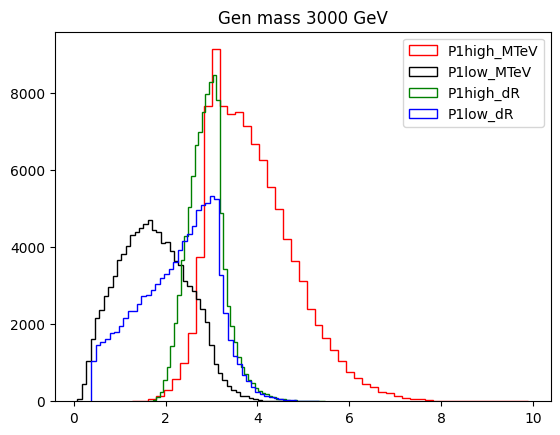

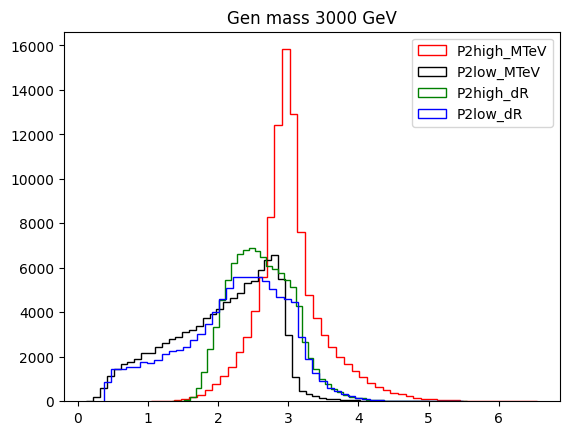

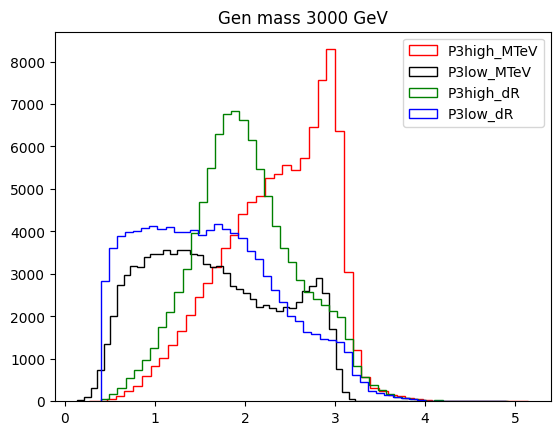

In [11]:
if SanityCheckPlots:
    for Mass in Masses:
        for Pair in ["P1", "P2", "P3"]:
            TrainingDF_temp = TrainingDF.loc[TrainingDF["Mass"] == Mass]
            plt.figure()
            plt.hist(TrainingDF_temp[Pair + "high_MTeV"], bins = 50, histtype = "step", color = "r", label = Pair + "high_MTeV")
            plt.hist(TrainingDF_temp[Pair + "low_MTeV"], bins = 50, histtype = "step", color = "k", label = Pair + "low_MTeV")
            plt.hist(TrainingDF_temp[Pair + "high_dR"], bins = 50, histtype = "step", color = "g", label = Pair + "high_dR")
            plt.hist(TrainingDF_temp[Pair + "low_dR"], bins = 50, histtype = "step", color = "b", label = Pair + "low_dR")
            plt.legend()
            plt.title("Gen mass " + str(Mass) + " GeV")

In [12]:
InputList = ["fourjetmasstev", "P1high_MTeV", "P1low_MTeV", "P1high_dR", "P1low_dR",
             "fourjetmasstev", "P2high_MTeV", "P2low_MTeV", "P2high_dR", "P2low_dR",
             "fourjetmasstev", "P3high_MTeV", "P3low_MTeV", "P3high_dR", "P3low_dR",]


TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [13]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(2400000, 15)
(2400000,)
(1200000, 15)


In [14]:
NotebookName = "SigBG_CNN"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [15]:
def model_CNN():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [16]:
def model_CNN_Dropout():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [17]:
def model_CNN_BatchNorm():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [18]:
def model_CNN_BatchNorm_Dropout():
    Model = tf.keras.Sequential()
    Model.add(tf.keras.Input(shape=(3*5, ), name="model_in"))
    Model.add(tf.keras.layers.Reshape((3,5, 1)))
    Model.add(tf.keras.layers.Conv2D(16, (2,3), activation='relu'))
    Model.add(tf.keras.layers.BatchNormalization())
    Model.add(tf.keras.layers.Dropout(0.2))
    Model.add(tf.keras.layers.Conv2D(8, (2,3), activation='relu'))
    Model.add(tf.keras.layers.BatchNormalization())
    Model.add(tf.keras.layers.Dropout(0.2))
    Model.add(tf.keras.layers.Flatten())
    Model.add(tf.keras.layers.Dense(3, activation='softmax', name="model_out"))

    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [19]:
Model = model_CNN()
#Model = model_CNN_Dropout()
#Model = model_CNN_BatchNorm()
#Model = model_CNN_BatchNorm_Dropout()

2023-12-06 15:54:49.009166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 15:54:49.846477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11311 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [20]:
Model.summary()

Model: "ModelCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 5, 1)           0         
                                                                 
 conv2d (Conv2D)             (None, 2, 3, 16)          112       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 8)           776       
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 model_out (Dense)           (None, 2)                 18        
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [21]:
import pydot
import graphviz
tf.keras.utils.plot_model(Model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(ResultsDir + "Model.h5", save_best_only = True, monitor = "val_loss", mode = "min")

History = Model.fit(TrainingInputs, TrainingTruth, batch_size = 5000,
                    epochs = 20, validation_split = 0.2, callbacks=[checkpoint])

Epoch 1/20


2023-12-06 15:54:52.223109: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


384/384 [==============================] - 4s 4ms/step - loss: 0.4596 - accuracy: 0.7804 - val_loss: 0.3496 - val_accuracy: 0.8462
Epoch 2/20
384/384 [==============================] - 1s 4ms/step - loss: 0.3809 - accuracy: 0.8315 - val_loss: 0.3395 - val_accuracy: 0.8513
Epoch 3/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3750 - accuracy: 0.8339 - val_loss: 0.3404 - val_accuracy: 0.8505
Epoch 4/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3718 - accuracy: 0.8354 - val_loss: 0.3349 - val_accuracy: 0.8530
Epoch 5/20
384/384 [==============================] - 1s 4ms/step - loss: 0.3693 - accuracy: 0.8365 - val_loss: 0.3339 - val_accuracy: 0.8532
Epoch 6/20
384/384 [==============================] - 1s 4ms/step - loss: 0.3675 - accuracy: 0.8373 - val_loss: 0.3331 - val_accuracy: 0.8532
Epoch 7/20
384/384 [==============================] - 1s 3ms/step - loss: 0.3662 - accuracy: 0.8377 - val_loss: 0.3413 - val_accuracy: 0.8490
Epoch 8/20
384/38

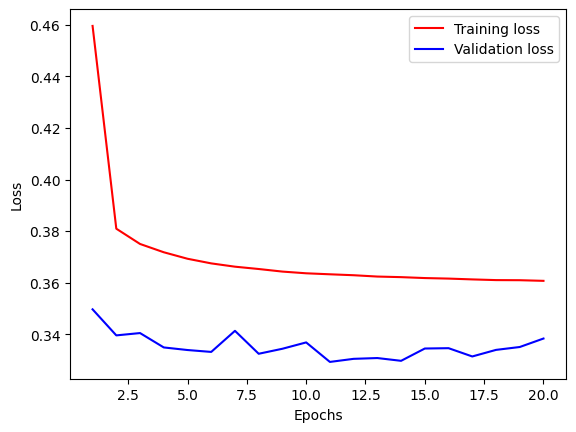

In [23]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [24]:
#Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict(TestingInputs, batch_size = 5000)

240/240 [==============================] - 0s 2ms/step


In [25]:
print(TestingOutputs.shape)
print(TestingOutputs[0]) #ML raw output is the probability of 2 sparse categories

(1200000, 2)
[0.02117123 0.97882885]


In [26]:
TestingDF["PredSigProb"] = TestingOutputs[:,1].tolist()
TestingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth,PredSigProb
0,1500,1,3.129592,1.647086,0.691324,1.594810,1.343082,1.166656,0.955612,2.468689,1.202926,2.884589,2.980161,1.826272,1.709282,1,0.978829
1,1500,1,3.014086,1.619434,0.751569,1.581018,1.202169,1.190105,0.775248,2.323982,1.536012,3.216929,2.790799,1.910045,1.257625,1,0.953289
2,1500,1,3.935945,2.193704,1.539645,2.049791,1.716259,0.851077,0.683049,2.863900,2.628241,3.056447,3.009341,1.015516,1.021851,1,0.969337
3,1500,1,5.119896,3.709561,1.005877,2.653745,1.499883,1.430991,0.382567,3.476613,2.611372,3.779490,2.340627,1.668311,0.560775,1,0.447916
4,1500,1,4.057911,2.596500,1.190106,1.526592,1.265432,1.492169,1.480011,3.020799,2.707161,1.970398,1.858787,1.963143,1.870544,1,0.988233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,2500,1,5.413437,4.122360,1.112320,2.638129,1.292240,1.281511,0.980640,3.023066,3.251436,2.617365,2.182220,1.142306,1.236344,1,0.880526
1199996,2500,1,5.951405,3.498623,0.509549,2.524925,2.224568,2.519068,2.306969,2.455730,0.494084,2.275941,2.234743,2.550645,2.544020,1,0.995546
1199997,2500,1,4.658836,2.854043,0.989743,2.155836,2.048336,1.685271,1.042166,3.101979,2.015382,3.156088,2.806784,2.992906,1.182892,1,0.940798
1199998,2500,1,6.329566,3.358283,2.604933,3.058393,1.083269,2.413451,2.390462,2.973725,2.604782,2.115519,1.063039,1.835820,1.924231,1,0.998106


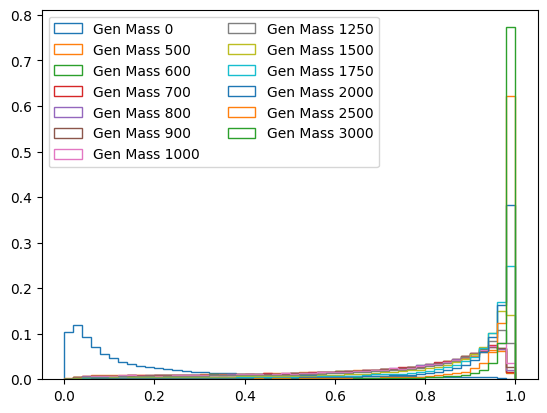

In [27]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]

    plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
             weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
             label = "Gen Mass " + str(Mass))
    plt.legend(ncol=2, loc="upper left")

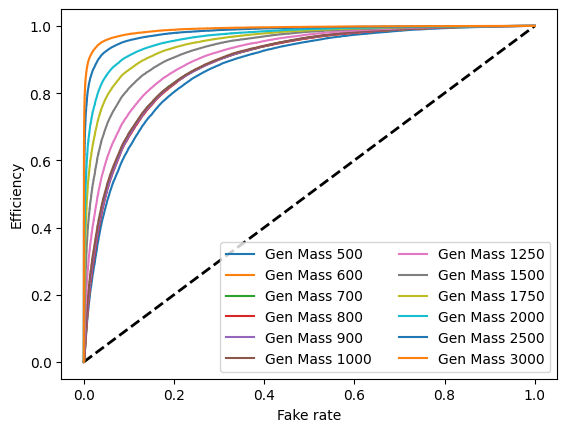

In [28]:
from sklearn.metrics import roc_curve, auc

TestingDF_QCD = TestingDF.loc[TestingDF["Mass"] == 0]
TestingDF_QCD = TestingDF_QCD.sample(frac = 1.0/12)

for Mass in Masses:
    if Mass == 0:
        plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")
    else:
        TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
        TestingDF_temp = pd.concat([TestingDF_temp, TestingDF_QCD], ignore_index=True)
        fpr, tpr, thresholds = roc_curve(TestingDF_temp["Truth"].to_numpy(),
                                         TestingDF_temp["PredSigProb"].to_numpy())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label = "Gen Mass " + str(Mass))
        plt.xlabel("Fake rate")
        plt.ylabel("Efficiency")
        plt.legend(ncol=2, loc="lower right")

In [29]:
TestingDF["Pred"] = (TestingDF["PredSigProb"] > 0.2).astype(int)

AccPred = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth"]]
    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))

In [30]:
AccPredAvg = "Avg %.2f" % float(sum(AccPred)/len(AccPred))

print(["%.2f" % i for i in AccPred], AccPredAvg)

['0.62', '0.92', '0.93', '0.93', '0.93', '0.93', '0.94', '0.95', '0.97', '0.98', '0.98', '0.99', '1.00'] Avg 0.93


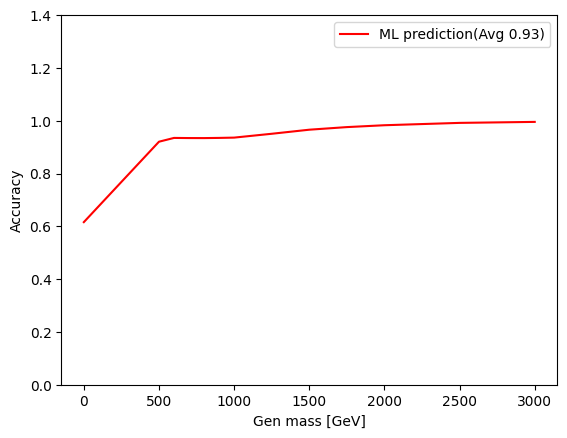

In [31]:
plt.plot(Masses, AccPred, "r", label = "ML prediction(" + AccPredAvg + ")")

plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")